<a href="https://colab.research.google.com/github/Paradiddle131/Translating-Sign-Language-to-Text-and-Audio/blob/master/TSL_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TODO:
- remove black edges

## Download Data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Core Functions

In [0]:
def mkdir(path):
  try:
    os.makedirs(path, exist_ok=True)
  except OSError:
    print("Folder already exists. Passing.")
    pass

In [0]:
def copy(From, to):
  if not os.path.isdir(to):
    os.mkdir(to)
  files = sorted(os.listdir(From))
  for f in files:
    shutil.copy(f'{From}/{f}', to)

In [0]:
def remove_files(path):
  for filename in os.listdir(path):
    file_path = os.path.join(path, filename)
    try:
        if os.path.isfile(file_path):
            os.remove(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

In [0]:
def count_files(path):
  return len(next(os.walk(path))[2])

## Import Libraries

In [0]:
import os
import shutil
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

Using TensorFlow backend.


In [0]:
ROOT = '/content/'
VID_DIR = os.path.join(ROOT, 'data/vid/cut/')
FRAMES_DIR = os.path.join(VID_DIR, 'frames/')
FRAMES_RESIZED_DIR = os.path.join(VID_DIR, 'frames_resized/')
FRAMES_BORDERLESS_DIR = os.path.join(VID_DIR, 'frames_borderless')
TARGET_SIZE = (90, 120)

## Extract Frames From Videos

In [0]:
mkdir(os.path.join(VID_DIR))
copy('/content/drive/My Drive/Dataset/fingers_dataset/cut/', VID_DIR)

In [0]:
mkdir(FRAMES_DIR)
for finger_no, vid in enumerate(sorted(glob.glob(VID_DIR+'*.mp4')), 1):
  i = 0
  path = FRAMES_DIR+str(finger_no)
  mkdir(path)
  cap = cv2.VideoCapture(vid)
  while(cap.isOpened()):
      ret, frame = cap.read()
      if ret == False:
          break
      cv2.imwrite(path+'/'+str(i)+'.jpg', frame)
      i += 1
 
cap.release()
cv2.destroyAllWindows()

In [0]:
# [remove_files(folder) for folder in glob.glob('/content/data/vid/cut/frames/*')]

## Data Analysis

Examine a Sample and Notice the Black Edges

(480, 720, 3)


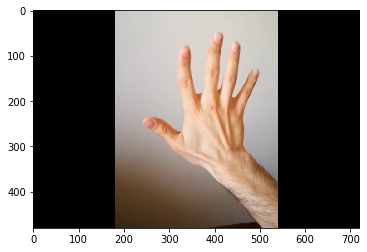

In [0]:
path = '/content/data/vid/cut/frames/5/0.jpg'
img = cv2.imread(path)
print(img.shape)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

Remove Black Edges

In [0]:
def remove_borders(img_path, target_path):
  img = cv2.imread(img_path)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  _,thresh = cv2.threshold(gray,1,255,cv2.THRESH_BINARY)
  contours, hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  cnt = contours[-1]
  x,y,w,h = cv2.boundingRect(cnt)
  # crop = cv2.cvtColor(img[y:y+h,x:x+w], cv2.COLOR_BGR2RGB)
  crop = img[y:y+h,x:x+w]
  # plt.imshow(crop)
  cv2.imwrite(target_path, crop)

In [0]:
mkdir(FRAMES_BORDERLESS_DIR)
for folder in sorted(os.listdir(FRAMES_DIR)):
  mkdir(os.path.join(FRAMES_BORDERLESS_DIR, folder))
  finger_path = os.path.join(FRAMES_DIR, folder)
  for file in sorted(os.listdir(finger_path)):
    remove_borders(os.path.join(finger_path, file), os.path.join(FRAMES_BORDERLESS_DIR, folder, file))

In [0]:
img1 = cv2.cvtColor(cv2.imread(os.path.join(FRAMES_DIR, '5', '1.jpg')), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread(os.path.join(FRAMES_BORDERLESS_DIR, '5', '1.jpg')), cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(10, 20))
fig.add_subplot(1, 2, 1)
plt.imshow(img1)
print(img1.shape)
fig.add_subplot(1, 2, 2)
plt.imshow(img2)
print(img2.shape)
plt.show()

Count Finger Images


In [0]:
values = [[(i, count_files(folder)) for i, folder in enumerate(glob.glob(FRAMES_DIR+'*'))][i][1] for i in range(5)]
y_pos = np.arange(1, len(values)+1)

plt.bar(y_pos, values, align='center')
plt.xticks(y_pos, values)
plt.ylabel('Count')
plt.title('Image count per finger')

plt.show()

In [0]:
train_size = 0
for value in values:
  train_size += value

Dimension Check

In [0]:
shapes = {}
i = 0
previous_shape = None
for folder in glob.glob(FRAMES_DIR+'*'):
  for file in glob.glob(folder+'/*'):
    img = cv2.imread(file)
    shape = img.shape
    if previous_shape != shape:
      previous_shape = shape
      i += 1
    shapes.update({i: previous_shape})
print(shapes)
if len(shapes) == 1:
  print(f"All images' shapes are equal to {img.shape}.")

Resize Images

In [0]:
mkdir(FRAMES_RESIZED_DIR)
for folder in sorted(os.listdir(FRAMES_BORDERLESS_DIR)):
  finger_path = os.path.join(FRAMES_BORDERLESS_DIR, folder)
  finger_resized_path = os.path.join(FRAMES_RESIZED_DIR, folder)
  mkdir(finger_resized_path)
  for file in sorted(os.listdir(finger_path)):
    path = os.path.join(finger_path, file)
    img = cv2.imread(path)
    img = cv2.resize(img, TARGET_SIZE)
    cv2.imwrite(os.path.join(finger_resized_path, file), img)

In [0]:
img1 = cv2.cvtColor(cv2.imread(os.path.join(FRAMES_DIR, '5', '1.jpg')), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread(os.path.join(FRAMES_RESIZED_DIR, '5', '1.jpg')), cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(10, 20))
fig.add_subplot(1, 2, 1)
plt.imshow(img1)
print(img1.shape)
fig.add_subplot(1, 2, 2)
plt.imshow(img2)
print(img2.shape)
plt.show()

## Dataset Preparation

In [0]:
data = []
labels = []

for folder in sorted(glob.glob(FRAMES_RESIZED_DIR+'*')):
  for file in sorted(glob.glob(folder+os.path.sep+'*')):
    img = cv2.imread(file)
    # img = cv2.resize(img, (image_width, image_height))
    img = img_to_array(img)
    data.append(img)
    label = int(file.split(os.path.sep)[-2]) - 1
    labels.append(label)

In [0]:
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [0]:
(X_train, X_test, Y_train, Y_test) = train_test_split(data,
	labels, test_size=0.2, random_state=131)

In [0]:
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

In [228]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 2560
number of test examples = 640
X_train shape: (2560, 120, 90, 3)
Y_train shape: (2560, 5)
X_test shape: (640, 120, 90, 3)
Y_test shape: (640, 5)


## Model Preparation